In [1]:
from glob import glob 
#file_list = glob("P" + "*.*", recursive = True)
file_list = glob("./Ossipee_Pine_Barrens_Jun2015_swath_refl_VIs/" + "*_*_at-sensor_refl_L1G",recursive = True)
for i in file_list:
    print("Element: " + i)
# print("List of filenames:", file_list)

Element: ./Ossipee_Pine_Barrens_Jun2015_swath_refl_VIs\Ossipee_Pine_Barrens_Jun2015_0_at-sensor_refl_L1G
Element: ./Ossipee_Pine_Barrens_Jun2015_swath_refl_VIs\Ossipee_Pine_Barrens_Jun2015_1_at-sensor_refl_L1G
Element: ./Ossipee_Pine_Barrens_Jun2015_swath_refl_VIs\Ossipee_Pine_Barrens_Jun2015_2_at-sensor_refl_L1G
Element: ./Ossipee_Pine_Barrens_Jun2015_swath_refl_VIs\Ossipee_Pine_Barrens_Jun2015_3_at-sensor_refl_L1G


In [2]:
import pandas as pd
metadata_list = glob("./Ossipee_Pine_Barrens_Jun2015_swath_refl_VIs/" + "*_*_at-sensor_refl_L1G.hdr")
header_info = pd.read_table(metadata_list[0], header=None)
# header_info = pd.read_table(file_list[1], header=None)
header_info.columns = ["metadata"]
print(header_info)

                                             metadata
0                                                ENVI
1                                     description = {
2   NASA G-LiHT, Ossipee_Pine_Barrens_Jun2015, Tra...
3                                       samples = 750
4                                      lines   = 4688
5                                       bands   = 114
6                                   header offset = 0
7                           file type = ENVI Standard
8                                       data type = 2
9                                    interleave = bsq
10                              sensor type = Unknown
11                                     byte order = 0
12  map info = {UTM, 1.000, 1.000, 326629.573, 485...
13  coordinate system string = {PROJCS["UTM_Zone_1...
14                         default bands = {54,33,15}
15                      wavelength units = Nanometers
16  z plot titles = {Wavelength (nm), Reflectance ...
17                      defa

In [3]:
##!pip install spectral
from spectral import *

In [4]:
# img = envi.open(file_list[1], )
# img1 = envi.open(file_list[3], )
# img2 = envi.open(file_list[5], )
img = envi.open(metadata_list[0], )
img1 = envi.open(metadata_list[1], )
img2 = envi.open(metadata_list[2], )

In [5]:
#Load image as an array
arr = img.load()
arr1 = img1.load()
arr2 = img2.load()

In [6]:
#Functions for working with images
import cv2
import matplotlib.pyplot as plt
import numpy as np

# def show_image(img1,img2,img3):
def show_image(img1):
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.imshow(img1, cmap = 'gray')
    # ax1.imshow(img2, cmap = 'gray')
    # ax1.imshow(img3, cmap = 'gray')

def increase_brightness(img, value=80):
    img = img.astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def create_rgb(hyper_cube):
    rgb_image = hyper_cube[:,:,[53,31,8]]
    rgb_image = cv2.normalize(rgb_image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    rgb_image = rgb_image.astype(np.uint8)
    rgb_image = increase_brightness(rgb_image)
    return rgb_image

In [7]:
def spectralSlicing(img, dim):
    #declaring variables
    inBounds = True
    x,y = 0,0
    ret = []
#     print(img.shape)
    while(inBounds):
        #slice dim pixels in x and y and then take all 114 wavelengths 
        frame = img[x:(x+dim),y:(y+dim),:]
        if(frame.any() != 0): #if the Frame is blank, don't append it
            ret.append(frame)
#         print(frame.shape)
        #indexing and edge detection
        x += dim
        if((x+dim) > img.shape[0]):
            x = 0
            y += dim
            if((y+dim) > img.shape[1]):
                inBounds = False
#    print(len(ret))
    return ret

In [8]:
def showframes(frames):
    for i in range(len(frames)):
        frame = create_rgb(frames[i])
        show_image(frame)

In [9]:
miniframes = spectralSlicing(img2,240)

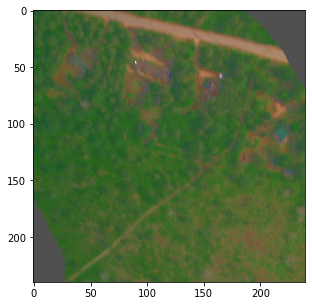

In [10]:
showframes(miniframes[11:12])

In [11]:
microframes = spectralSlicing(miniframes[0],80)

In [12]:
#find different colors

colorsearchFrames = []
for i in range(len(microframes)):
    for x in range(microframes[i].shape[0]):
        for y in range(microframes[i].shape[1]):
            if(microframes[i][x,y,8] > 200):
                if(len(colorsearchFrames) < 5):
                    colorsearchFrames.append(microframes[i])
                    if(i<len(microframes)):
                        i+=1
# showframes(colorsearchFrames[:])

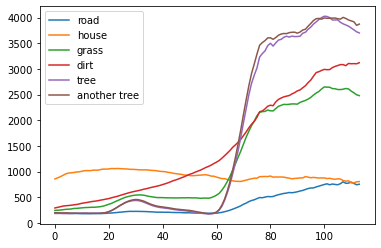

In [13]:
import matplotlib.pyplot as plt
plt.plot(colorsearchFrames[4][10,10,0:],label="road")  #road?
plt.plot(colorsearchFrames[4][60,79,0:],label="house") #House?
plt.plot(colorsearchFrames[4][60,70,0:],label="grass") #grass?
plt.plot(colorsearchFrames[4][50,60,0:],label="dirt")  #dirt
plt.plot(colorsearchFrames[4][60,20,0:],label="tree")  #tree
plt.plot(colorsearchFrames[4][70,10,0:],label="another tree")  #tree
plt.legend()

In [14]:
def isTreePixbyPix(frame):
    treePixels = []
    nonTreePixels = []
    for x in range(frame.shape[0]):
        for y in range(frame.shape[1]):
            if(frame[x,y,100] > 2800 and (frame[x,y,60] < frame[x,y,80]-2000) and (frame[x,y,60] < frame[x,y,25]) ):
                treePixels.append([frame[x,y,:],1])
            if(frame[x,y,80] < 2500 or (frame[x,y,60] > frame[x,y,80]-2000) or (frame[x,y,60] > frame[x,y,25])):
                nonTreePixels.append([frame[x,y,:],0])
    return treePixels, nonTreePixels
t, n = isTreePixbyPix(miniframes[11])
t2,n2 = isTreePixbyPix(miniframes[4])
print(len(t))
print(len(n))

2741
55034


In [16]:
#create HP5 file of training data 
import h5py


t = t + n 
t2 = t2 + n2
# t = data
# print(len(data))
# print(len(t))
np.random.shuffle(t)
np.random.shuffle(t2)

testingData, testingLabels = zip(*t2)
trainingData, trainingLabels = zip(*t)




hf = h5py.File('treeVSnot.h5','w')
hf.create_dataset('trainingData', data=trainingData)
hf.create_dataset('trainingLabels', data=trainingLabels)
hf.create_dataset('testingData', data=testingData)
hf.create_dataset('testingLabels', data=testingLabels)

hf.close()

# Improvements    
filter out the dirt       
make sure that data set is accurate      
get more data


In [17]:
#check for dirt pixels that slip into the data
x, y = trainingData, trainingLabels
for i in range(len(x)):
    if(x[i][60] > (x[i][80] - 1500) and y[i] == 1):
        print(i)
        plt.plot(x[i])
        